# ROC curves and MDS

This jupyter notebook contains the scripts used to create the ROC curves and MDS in the Metage2Metabo article.

The scripts dependencies are (with version used for the article):

- matplotlib==3.3.1
- numpy==1.17.4
- pandas==0.23.4
- scikit-learn==0.23.1
- seaborn==0.9.0


It uses three files:

- `addedvalue.tsv`: cooperation potential composition for each microbiome.
- `community_scopes.tsv`: community scope for each microbiome.
- `metadata.csv`: metadata of the experience from MICOM article.

It creates 4 files:

- `roc_subset_cohort_comscope.pdf`: ROC curves of classification between cohort (MHD/SWE) using community scope.
- `mds_subset_cohort_comscope.pdf`: Two dimension MDS, with color on cohort (purple: MHD, yellow: SWE) using community scope.
- `roc_subset_cohort_addedvalue.pdf`: ROC curves of classification between cohort (MHD/SWE) using addedvalue.
- `roc_status_addedvalue.pdf`: ROC curves of classification between disease status for the MHD cohort (control, Type-1 Diabetes or Type-2 Diabetes) using addedvalue.

## Community scope and cohort

### ROC curve

This script was used to create the ROC curve of the **Appendix 3 Figure 1 c**.

Classification experiment aiming at separating the cohort (MHD n=115, SWE n=55) based on the occurrences of metabolites in the community scope.

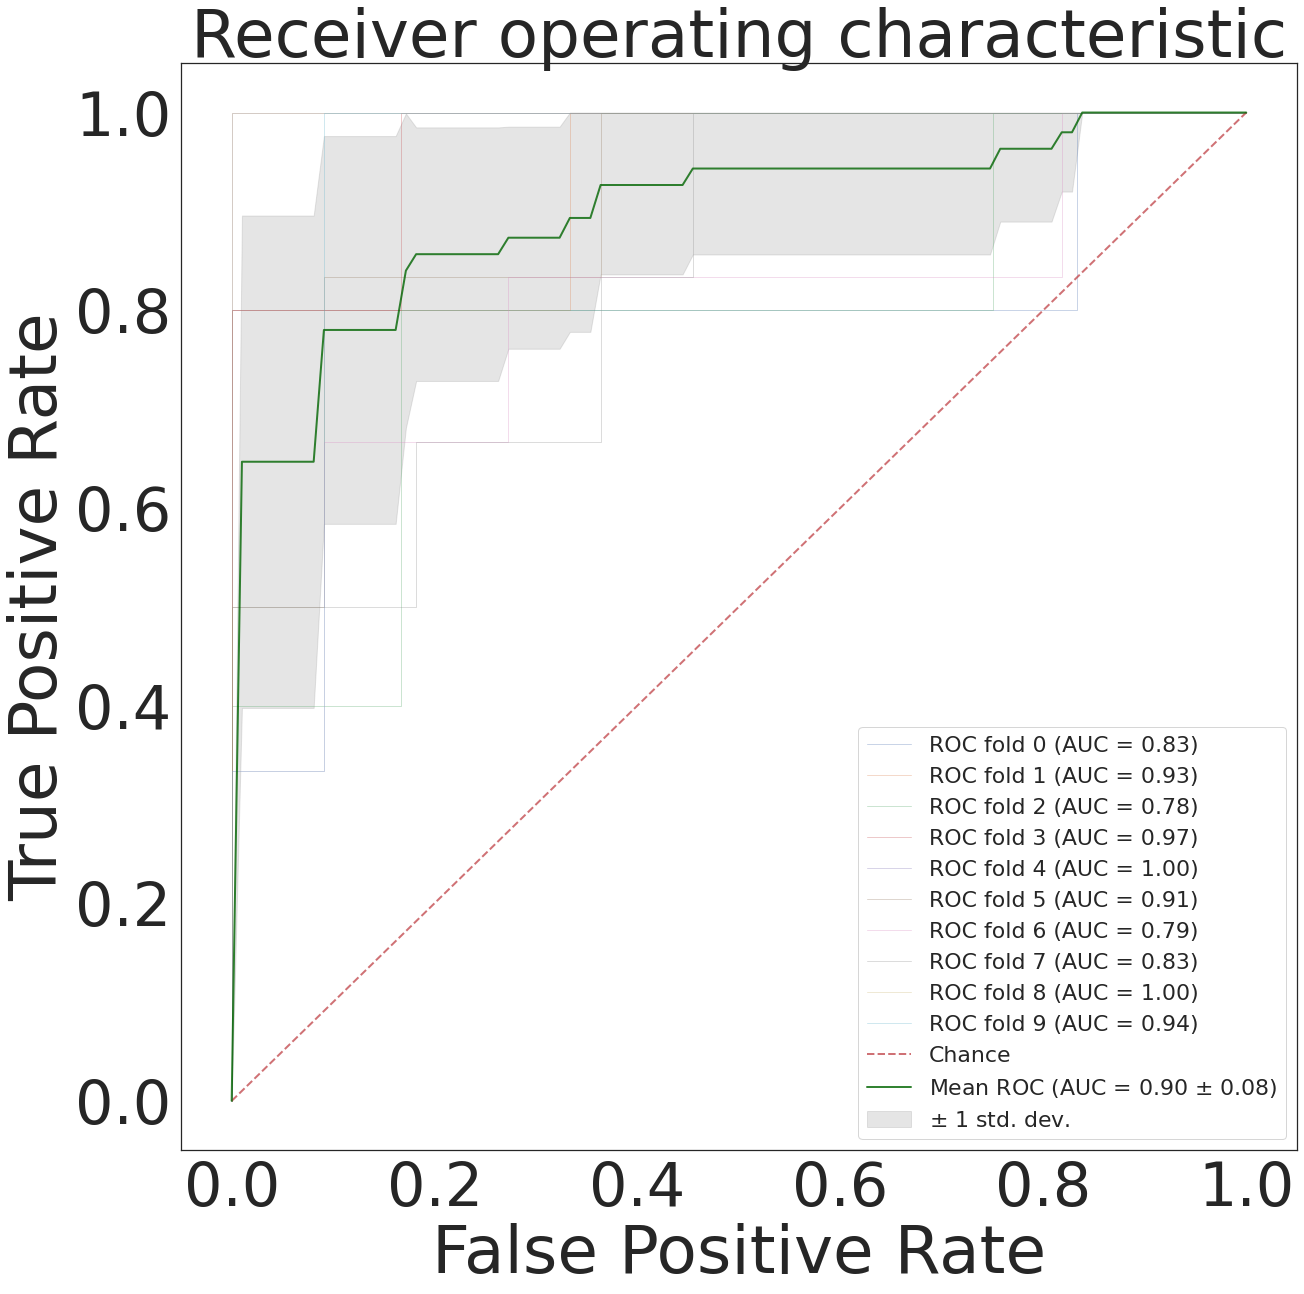

In [14]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pa
import seaborn as sns

from sklearn import svm
from sklearn.metrics import auc, plot_roc_curve
from sklearn.model_selection import StratifiedKFold

from sklearn.manifold import MDS

sns.set(font_scale=5.5)
sns.set_style("white")


# Read community scope file
df_data = pa.read_csv('community_scopes.tsv', sep='\t')

df_data.set_index('Unnamed: 0', inplace=True)

# Remove data with low abundancy.
remove_low_abundancies = [
'MH0037',
'MH0058',
'MH0084',
'MH0038',
'MH0065',
'MH0067',
'MH0073',
'MH0082',
'MH0035',
'MH0064',
'MH0054',
'MH0077',
'NG5425286',
'NG5425485',
'MH0057',
'MH0047'
]

for to_remove in remove_low_abundancies:
    if to_remove in df_data.index:
        df_data = df_data.drop(to_remove)

# Read metadata file
df_metadata = pa.read_csv('metadata.csv', sep=',')
df_metadata.set_index('sample', inplace=True)

# Join metadata and community scope files.
df_join = df_data.join(df_metadata)

# Replace MHD/SWE values with binary numerical data.
df_join = df_join.replace('MHD', 0)
df_join = df_join.replace('SWE', 1)

columns = df_data.columns.tolist()
X = df_join[columns]
y = df_join['subset']

# Reduce the dimension with a MDS
embedding = MDS(n_components=186)
X_transformed = embedding.fit_transform(X)
X = X_transformed

X, y = X[y != 2], y[y != 2]
n_samples, n_features = X.shape

# Add noisy features
random_state = np.random.RandomState(4)
X = np.c_[X]

# Classification and ROC analysis.

# Run classifier with cross-validation and plot ROC curves.
cv = StratifiedKFold(n_splits=10)
classifier = svm.SVC(kernel='linear', probability=True, random_state=random_state)

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

# Create figure and axes.
fig, ax = plt.subplots(figsize=[20,20])

# Compute ROC for each test.
for i, (train, test) in enumerate(cv.split(X, y)):
    classifier.fit(X[train], y[train])
    viz = plot_roc_curve(classifier, X[test], y[test],
                         name='ROC fold {}'.format(i),
                         alpha=0.3, lw=1, ax=ax)
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

# Add chance diagonal.
ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='darkgreen',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                label=r'$\pm$ 1 std. dev.')

# Add legend.
ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="Receiver operating characteristic")
ax.legend(loc="lower right", fontsize=22)

# Save the picture.
plt.savefig('roc_subset_cohort_comscope.pdf')

### MDS

This script was used to create the MDS (MHD n=115, SWE n=55) of the **Appendix 3 Figure 1 d**.

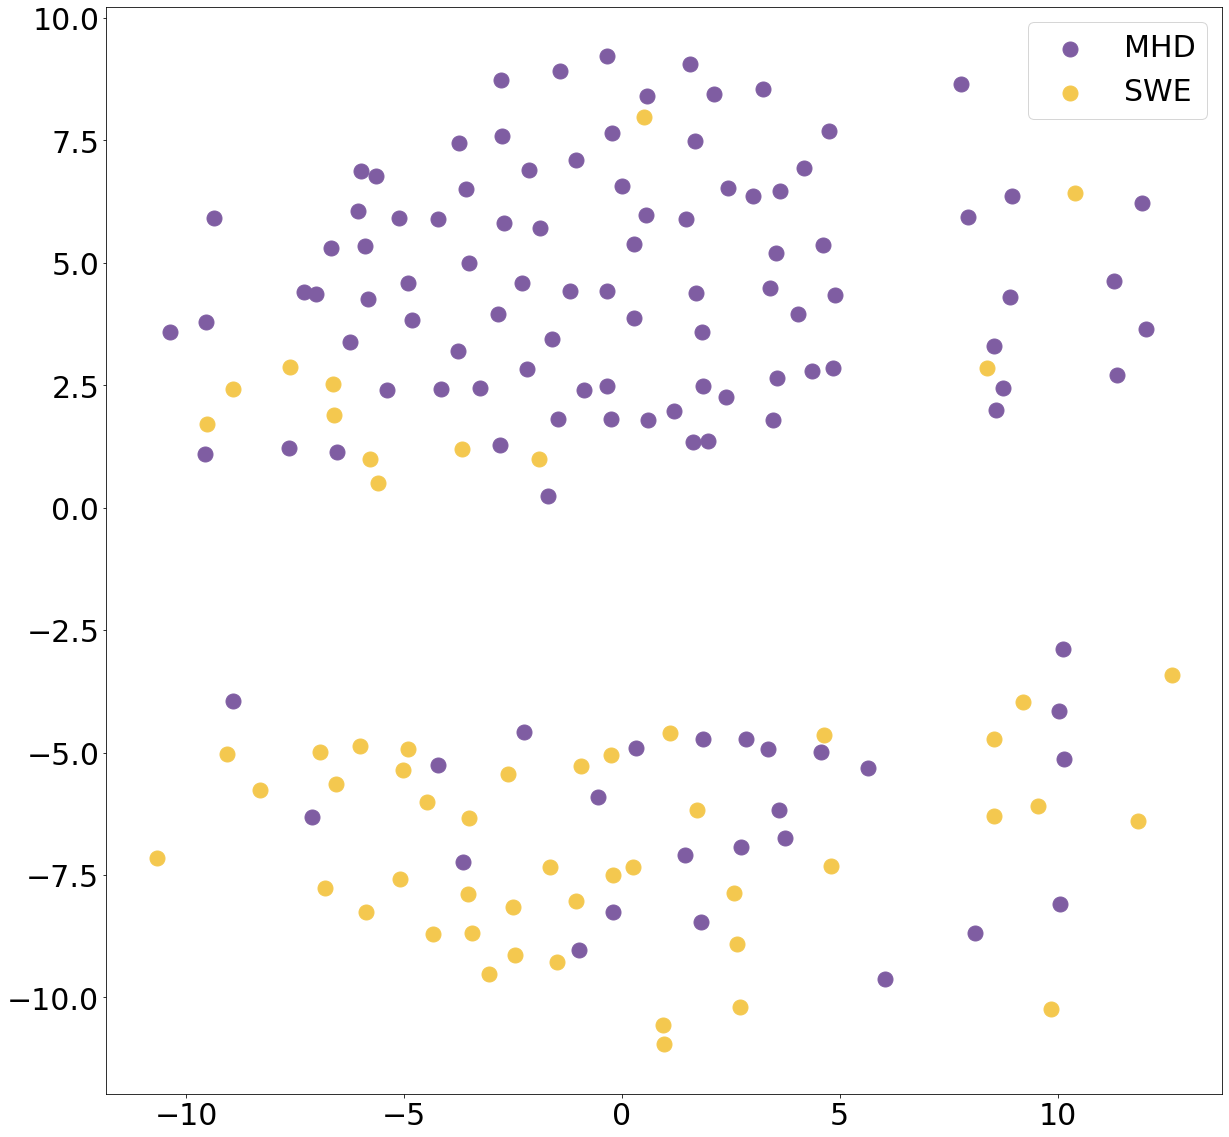

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pa

from sklearn.manifold import MDS

# read community scope input file.
df_data = pa.read_csv('community_scopes.tsv', sep='\t')

df_data.set_index('Unnamed: 0', inplace=True)

# Remove data with low abundancy.
remove_species = [
'MH0037',
'MH0058',
'MH0084',
'MH0038',
'MH0065',
'MH0067',
'MH0073',
'MH0082',
'MH0035',
'MH0064',
'MH0054',
'MH0077',
'NG5425286',
'NG5425485',
'MH0057',
'MH0047'
]
for i in remove_species:
    if i in df_data.index:
        df_data = df_data.drop(i)

# Read metadata file.
df_metadata = pa.read_csv('metadata.csv', sep=',')
df_metadata.set_index('sample', inplace=True)

# Join metadata and community scope files.
df_join = df_data.join(df_metadata)

# Replace each data by a number.
df_join = df_join.replace('MHD', 0)
df_join = df_join.replace('SWE', 1)

X = df_join[df_data.columns.tolist()]
y = df_join['subset']

# MDS on 2 dimensions.
embedding = MDS(n_components=2)
X_transformed = embedding.fit_transform(X)
X = X_transformed

# Link a number to each group.
groups = {0: 'MHD', 1: 'SWE'}

# Use specific colors: purple for MHD and yellow for SWE.
# The index of each color correspond to teh number of the linked group.
colors = ["#7f5da2",'#f4c84f']

# Adapt figure size and font.
plt.rcParams['figure.figsize'] = [20, 20]
plt.rc('font', size=30)

for i in np.unique(df_join.subset):
    subset = X[df_join.subset == i]
    labels = df_join[df_join.subset == i].index
    
    x = [row[0] for row in subset]
    y = [row[1] for row in subset]
    plt.scatter(x,y,c=colors[i],label=groups[i],s=15**2)

    # Uncomment the following lines to see the ID of each data.
    #for i, data in enumerate(x):
        #plt.annotate(labels[i], (x[i],y[i]))

# Modify legend size.
plt.legend(prop={'size': 30}, fontsize=22)

plt.savefig("mds_subset_cohort_comscope.pdf")

## Addedvalue and cohort

This script was used to create the ROC curve of the **Appendix 3 Figure 1 g**.

Classification experiment aiming at separating the cohort (MHD n=115, SWE n=55) based on the occurrences of metabolites in the cooperation potential.

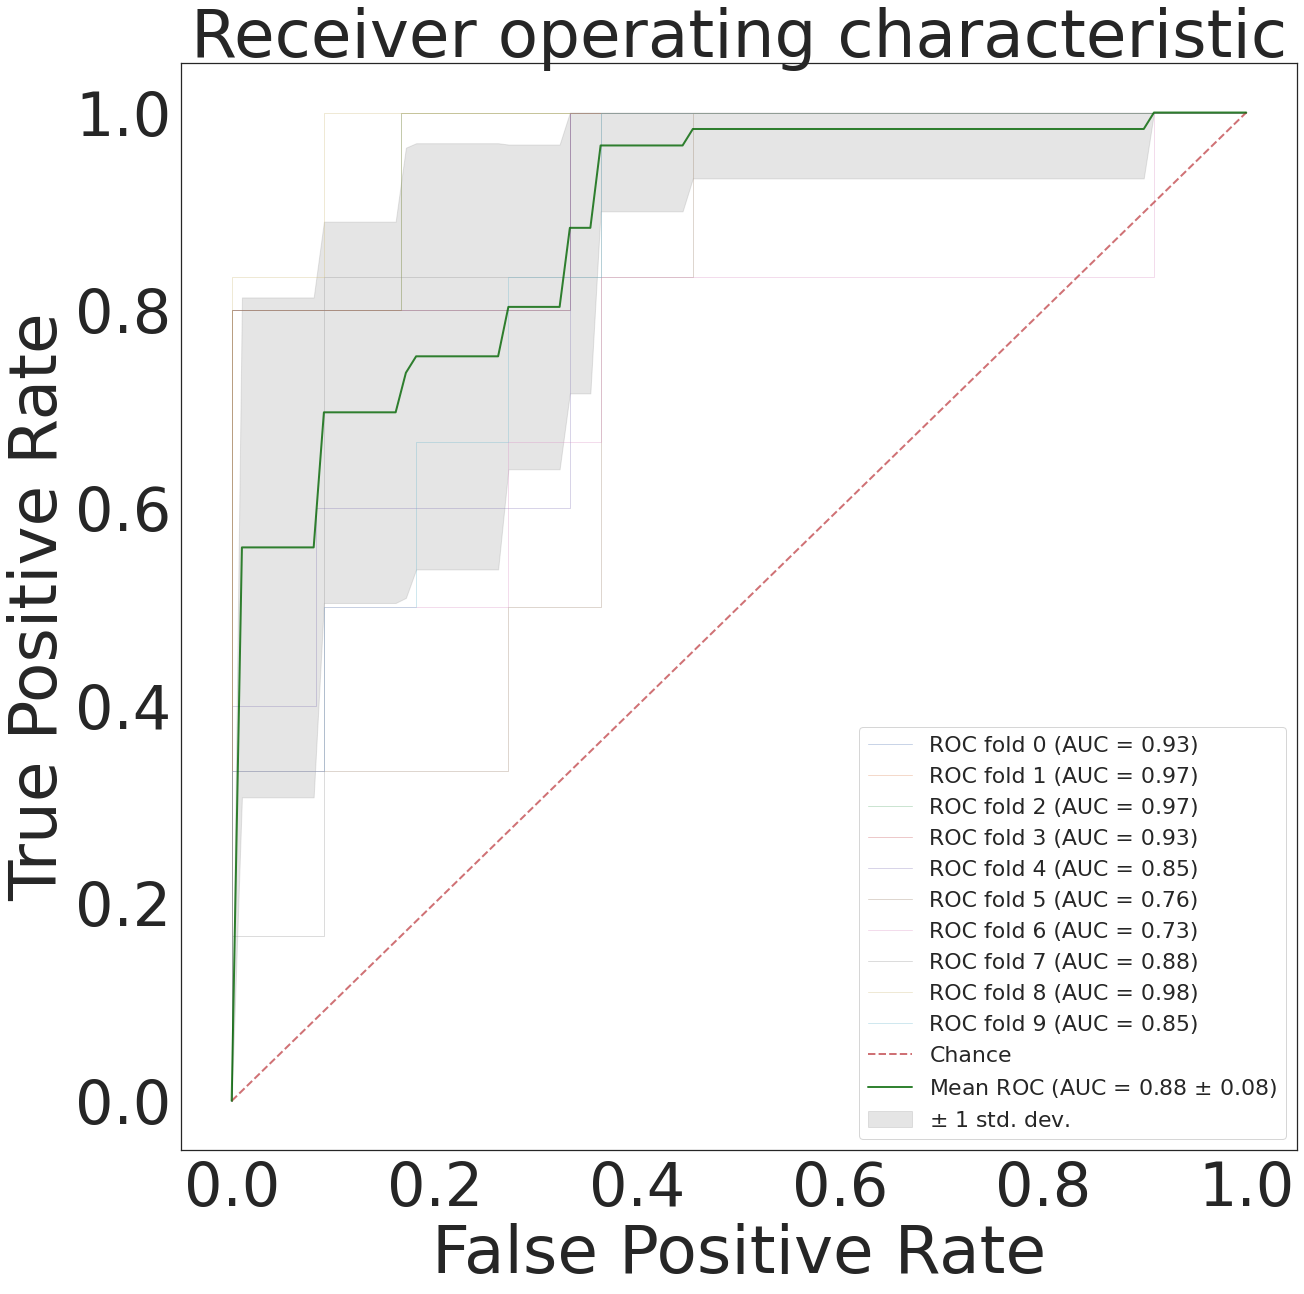

In [23]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pa
import seaborn as sns

from sklearn import svm
from sklearn.metrics import auc, plot_roc_curve
from sklearn.model_selection import StratifiedKFold

from sklearn.manifold import MDS

sns.set(font_scale=5.5)
sns.set_style("white")


# Read addedvalue file
df_data = pa.read_csv('addedvalue.tsv', sep='\t')

df_data.set_index('Unnamed: 0', inplace=True)

# Remove data with low abundancy.
remove_low_abundancies = [
'MH0037',
'MH0058',
'MH0084',
'MH0038',
'MH0065',
'MH0067',
'MH0073',
'MH0082',
'MH0035',
'MH0064',
'MH0054',
'MH0077',
'NG5425286',
'NG5425485',
'MH0057',
'MH0047'
]

for to_remove in remove_low_abundancies:
    if to_remove in df_data.index:
        df_data = df_data.drop(to_remove)

# Read metadata file
df_metadata = pa.read_csv('metadata.csv', sep=',')
df_metadata.set_index('sample', inplace=True)

# Join metadata and addedvalue files.
df_join = df_data.join(df_metadata)

# Replace MHD/SWE values with binary numerical data.
df_join = df_join.replace('MHD', 0)
df_join = df_join.replace('SWE', 1)

columns = df_data.columns.tolist()
X = df_join[columns]
y = df_join['subset']

# Reduce the dimension with a MDS
embedding = MDS(n_components=186)
X_transformed = embedding.fit_transform(X)
X = X_transformed

X, y = X[y != 2], y[y != 2]
n_samples, n_features = X.shape

# Add noisy features
random_state = np.random.RandomState(4)
X = np.c_[X]

# Classification and ROC analysis.

# Run classifier with cross-validation and plot ROC curves.
cv = StratifiedKFold(n_splits=10)
classifier = svm.SVC(kernel='linear', probability=True, random_state=random_state)

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

# Create figure and axes.
fig, ax = plt.subplots(figsize=[20,20])

# Compute ROC for each test.
for i, (train, test) in enumerate(cv.split(X, y)):
    classifier.fit(X[train], y[train])
    viz = plot_roc_curve(classifier, X[test], y[test],
                         name='ROC fold {}'.format(i),
                         alpha=0.3, lw=1, ax=ax)
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

# Add chance diagonal.
ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='darkgreen',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                label=r'$\pm$ 1 std. dev.')

# Add legend.
ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="Receiver operating characteristic")
ax.legend(loc="lower right", fontsize=22)

# Save the picture.
plt.savefig('roc_subset_cohort_addedvalue.pdf')

## Addedvalue and disease status

This script was used to create the ROC curve of the **Appendix 4 Figure 1 a**.

Classification experiment aiming at deciphering the disease status for the MHD cohort (control n=49, Type-1 Diabetes n=31 or Type-2 Diabetes n=35) based on the cooperation potential composition (addedvalue).

The figure has three main curves:

- Green: Control versus Type-1 Diabetes
- Black: Control versus Type-2 Diabetes
- Orange: Type-1 Diabetes versus Type-2 Diabetes

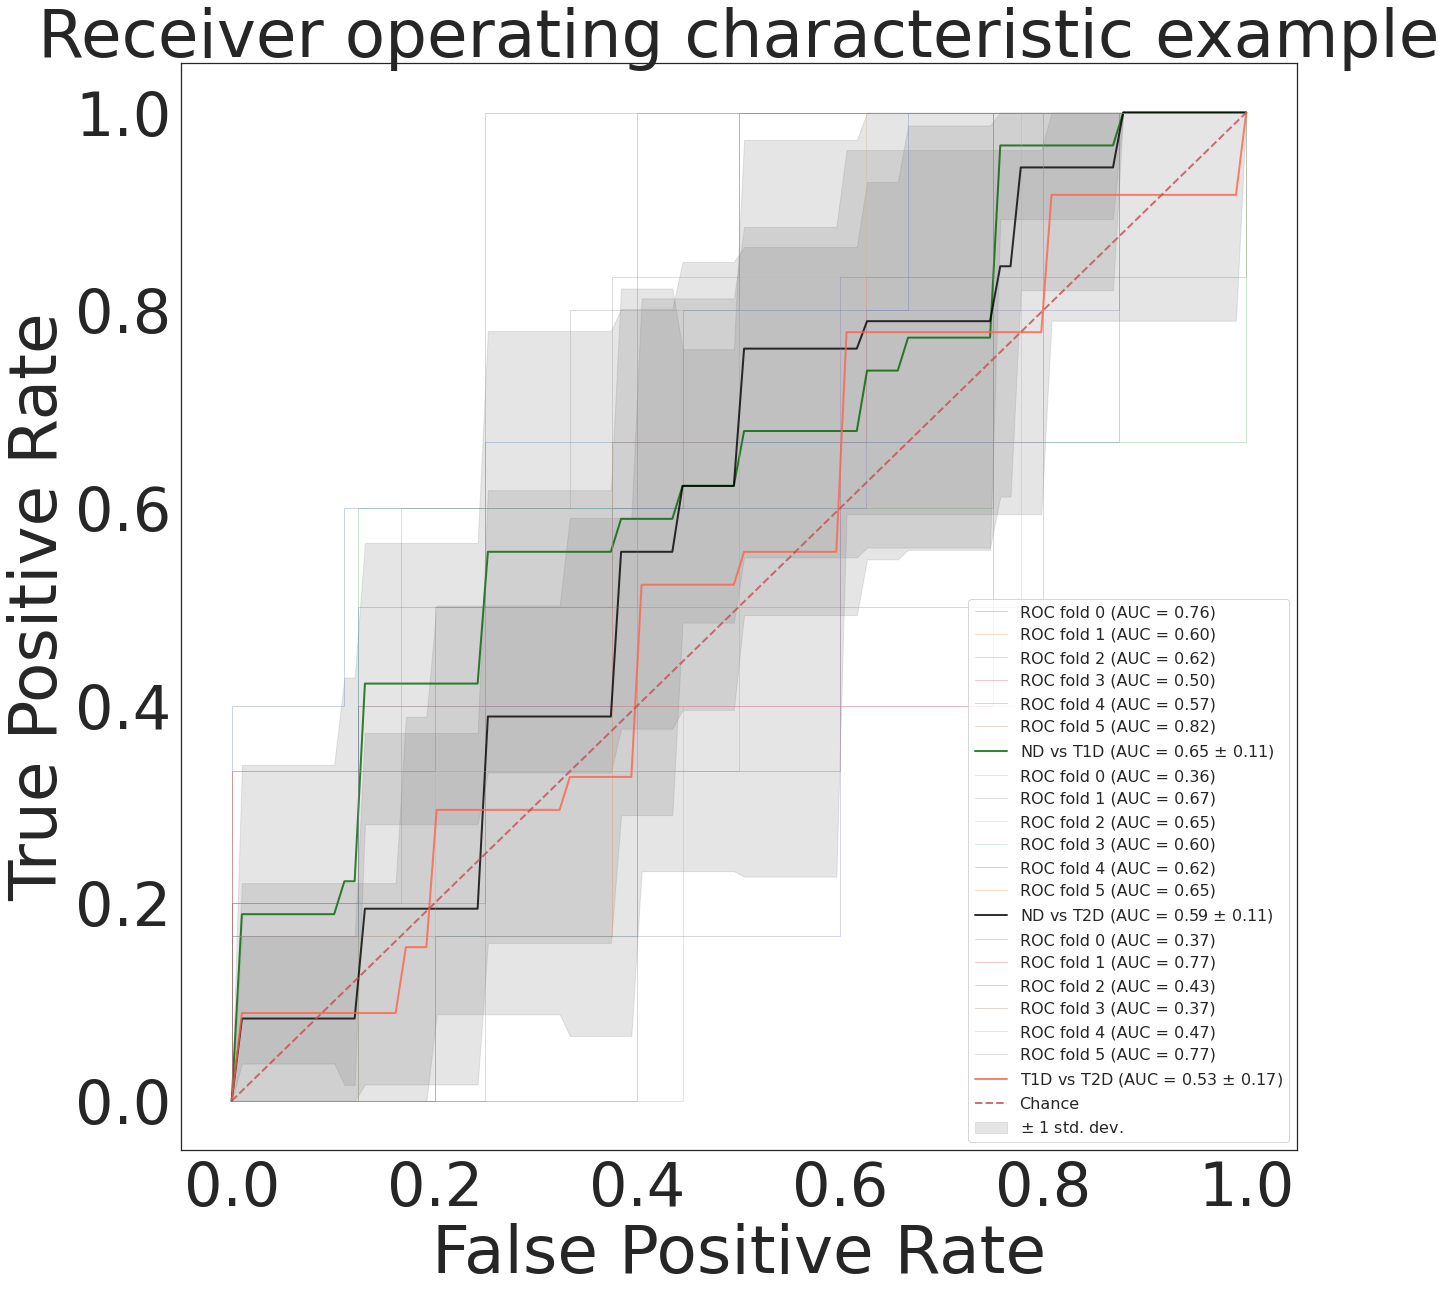

In [10]:
import matplotlib.pyplot as plt
import pandas as pa
import numpy as np
import seaborn as sns

from sklearn.metrics import auc, plot_roc_curve
from sklearn import svm
from sklearn.manifold import MDS
from sklearn.model_selection import StratifiedKFold

sns.set(font_scale=5.5)
sns.set_style("white")

# Read the addedvalue file.
df_data = pa.read_csv('addedvalue.tsv', sep='\t')

df_data.set_index('Unnamed: 0', inplace=True)

# Remove data with low abundancy.
remove_low_abundancies = [
'MH0037',
'MH0058',
'MH0084',
'MH0038',
'MH0065',
'MH0067',
'MH0073',
'MH0082',
'MH0035',
'MH0064',
'MH0054',
'MH0077',
'NG5425286',
'NG5425485',
'MH0057',
'MH0047'
]
for to_remove in remove_low_abundancies:
    if to_remove in df_data.index:
        df_data = df_data.drop(to_remove)

# Read the metadata file.
df_metadata = pa.read_csv('metadata.csv', sep=',')
df_metadata.set_index('sample', inplace=True)

# Join metadata and community scope/
df_join = df_data.join(df_metadata)

# Analysis is run only on the MHD cohort.
df_join = df_join[df_join['subset'] == 'MHD']

# Initiate classifier.
svm_clf = svm.SVC(kernel='linear')

# Control versus T1D.
df_join1= df_join[(df_join['status']=='ND') | (df_join['status']=='T1D')]
df_join1 = df_join1.replace('ND', 0)
df_join1 = df_join1.replace('T1D', 1)

columns = df_data.columns.tolist()
X = df_join1[columns]
y = df_join1['status']

# Reduction of dimension with a MDS.
embedding = MDS(n_components=100)
X_transformed = embedding.fit_transform(X)
X = X_transformed

# Run classifier with cross-validation and plot ROC curves.
cv = StratifiedKFold(n_splits=6)

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

fig, ax = plt.subplots(figsize=[20,20])
for i, (train, test) in enumerate(cv.split(X, y)):
    svm_clf.fit(X[train], y[train])
    viz = plot_roc_curve(svm_clf, X[test], y[test],
                         name='ROC fold {}'.format(i),
                         alpha=0.3, lw=1, ax=ax)
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='darkgreen',
        label=r'ND vs T1D (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                label=r'$\pm$ 1 std. dev.')

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="Receiver operating characteristic example")
ax.legend(loc="lower right")

# Control versus T2D.
df_join2 = df_join[(df_join['status']=='ND') | (df_join['status']=='T2D')]
df_join2 = df_join2.replace('ND', 0)
df_join2 = df_join2.replace('T2D', 1)

columns = df_data.columns.tolist()
X = df_join2[columns]
y = df_join2['status']

embedding = MDS(n_components=100)
X_transformed = embedding.fit_transform(X)
X = X_transformed
# Run classifier with cross-validation and plot ROC curves
cv = StratifiedKFold(n_splits=6)

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

for i, (train, test) in enumerate(cv.split(X, y)):
    svm_clf.fit(X[train], y[train])
    viz = plot_roc_curve(svm_clf, X[test], y[test],
                         name='ROC fold {}'.format(i),
                         alpha=0.3, lw=1, ax=ax)
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='black',
        label=r'ND vs T2D (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2)

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="Receiver operating characteristic example")
ax.legend(loc="lower right")

# T1D versus T2D.
df_join3 = df_join[(df_join['status']=='T1D') | (df_join['status']=='T2D')]
df_join3 = df_join3.replace('T1D', 0)
df_join3 = df_join3.replace('T2D', 1)

columns = df_data.columns.tolist()
X = df_join3[columns]
y = df_join3['status']

embedding = MDS(n_components=100)
X_transformed = embedding.fit_transform(X)
X = X_transformed

# Run classifier with cross-validation and plot ROC curves
cv = StratifiedKFold(n_splits=6)

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

for i, (train, test) in enumerate(cv.split(X, y)):
    svm_clf.fit(X[train], y[train])
    viz = plot_roc_curve(svm_clf, X[test], y[test],
                         name='ROC fold {}'.format(i),
                         alpha=0.3, lw=1, ax=ax)
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='tomato',
        label=r'T1D vs T2D (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)

ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2)
ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="Receiver operating characteristic example")

# Add chance diagonal.
ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Chance', alpha=.8)
ax.legend(loc="lower right", fontsize=16)

plt.savefig('roc_status_addedvalue.pdf')